In [30]:
!pip install -q gdown

!gdown --folder 13zAx4iT7uEXcD4Kmn34Kvz-gIFfrCYrm -O midterm_folder

Retrieving folder contents
Processing file 1mFJpyb7sXz1yQnzZAMOcDrU_sqKs-6PB test_transaction.csv
Processing file 1qoZrVs3t1uo-x508Wu_OcWjbOTF1Umoa train_transaction.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1mFJpyb7sXz1yQnzZAMOcDrU_sqKs-6PB
From (redirected): https://drive.google.com/uc?id=1mFJpyb7sXz1yQnzZAMOcDrU_sqKs-6PB&confirm=t&uuid=38b8cb5a-9b2a-4888-b71d-3fee9fa29306
To: /content/midterm_folder/test_transaction.csv
100% 613M/613M [00:06<00:00, 88.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1qoZrVs3t1uo-x508Wu_OcWjbOTF1Umoa
From (redirected): https://drive.google.com/uc?id=1qoZrVs3t1uo-x508Wu_OcWjbOTF1Umoa&confirm=t&uuid=f6cdb1b9-7b95-48a9-8722-ec9734494d97
To: /content/midterm_folder/train_transaction.csv
100% 683M/683M [00:03<00:00, 222MB/s]
Download completed


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

In [5]:
def find_file(folder, key):
    for f in os.listdir(folder):
        if key in f:
            return os.path.join(folder, f)
    return None

In [6]:
folder = "/content/drive/MyDrive/FraudTransaction"

In [7]:
train_path = find_file(folder, "train")
print("Train file:", train_path)

Train file: /content/drive/MyDrive/FraudTransaction/train_transaction.csv


In [8]:
test_path = find_file(folder, "test")
print("Test file:", test_path)

Test file: /content/drive/MyDrive/FraudTransaction/test_transaction.csv


In [9]:
assert train_path is not None, "Train file not found!"
assert test_path is not None, "Test file not found!"

In [10]:
import pandas as pd

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print(train.shape)
print(test.shape)

(590540, 394)
(506691, 393)


In [14]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
train['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.96501
1,0.03499


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

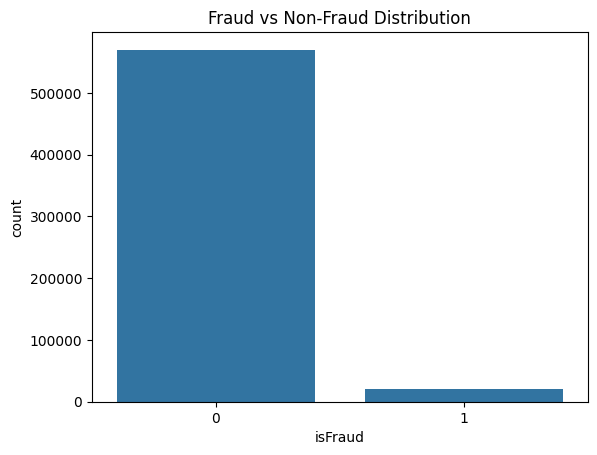

In [19]:
sns.countplot(x='isFraud', data=train)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

In [11]:
train = train.sample(200_000, random_state=42)
print(train.shape)

(200000, 394)


In [12]:
y = train['isFraud']
X = train.drop(['isFraud'], axis=1)

In [13]:
print(X.shape)
print(y.shape)

(200000, 393)
(200000,)


In [14]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include="object").columns

print("Numerical:", len(num_cols))
print("Categorical:", len(cat_cols))


Numerical: 379
Categorical: 14


In [15]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])


In [16]:
#Neural Network Fraud Model
model = Pipeline([
    ("prep", preprocessor),
    ("nn", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=10,
        random_state=42
    ))
])


In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

model.fit(X_train, y_train)

val_pred = model.predict_proba(X_val)[:, 1]
roc = roc_auc_score(y_val, val_pred)

print("ROC-AUC:", roc)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


ROC-AUC: 0.8890070386027935


In [19]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     38580
           1       0.79      0.41      0.54      1420

    accuracy                           0.98     40000
   macro avg       0.89      0.70      0.76     40000
weighted avg       0.97      0.98      0.97     40000



In [20]:
test_pred = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({
    "TransactionID": test["TransactionID"],
    "isFraud": test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.000104
1,3663550,0.000133
2,3663551,0.003366
3,3663552,0.001872
4,3663553,0.000540
